In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.primitives import Estimator
from ffsim import qiskit as fqs
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from ffsim.qiskit.jordan_wigner import jordan_wigner


from typing import Sequence
import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

import quimb as qu
import quimb.tensor as qtn
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
import pandas as pd
import matplotlib.pyplot as plt

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}
 
def create_linear_chains(norb: int) -> PyGraph:
    G = rustworkx.PyGraph()
 
    for n in range(norb):
        G.add_node(n)
 
    for n in range(norb - 1):
        G.add_edge(n, n + 1, None)
 
    for n in range(norb, 2 * norb):
        G.add_node(n)
 
    for n in range(norb, 2 * norb - 1):
        G.add_edge(n, n + 1, None)
 
    return G
 
def create_lucj_zigzag_layout(norb: int, backend_coupling_graph: PyGraph) -> tuple[PyGraph, int]:
    #Mapped to to an IBM QPU with heavy-hex connectivity
    isomorphic = False
    G = create_linear_chains(norb=norb)
    nit = norb
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(nit):
            if n % 4 == 0:
                new_node = 2 * norb + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + norb, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(backend_coupling_graph, G_new)
        nit -= 1
    return G_new, num_alpha_beta_qubits
 
 
def lightweight_layout_error_scoring(backend: BackendV2, virtual_edges: Sequence[Sequence[int]],physical_layouts: Sequence[int],two_q_gate_name: str,) -> list[list[list[int], float]]:
    # score isomporphic layouts based on the error rates of the qubits and couplers
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])
  
def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()
 
    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass
 
    return backend_coupling_graph
 
 
def get_zigzag_physical_layout(num_orbitals: int, backend: BackendV2, score_layouts: bool = True) -> tuple[list[int], int]:

    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)
 
    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        norb=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )
 
    isomorphic_mappings = rustworkx.vf2_mapping(backend_coupling_graph, G, subgraph=True)
    isomorphic_mappings = list(isomorphic_mappings)
 
    edges = list(G.edge_list())
 
    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)
 
    two_q_gate_name = IBM_TWO_Q_GATES.intersection(backend.configuration().basis_gates).pop()
 
    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )
 
        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits
 
    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits


/home/david/.venvs/tikzplot/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Classical chemistry

- Build $H_2$ molecule, basis, units, bond length
- obtain molecular and one and two electron integrals (hcore, eri) which define the fermionic electronic Hamiltonian
- use t1 and t2 amplitudes from ccsd ansatz to initialize lucj

In [2]:
# Specify molecule properties
open_shell = False
spin_sq = 0
 

R = 0.8

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (R, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
norb = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, norb, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), norb)


converged SCF energy = -108.40735863448


In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2635773151639  E_corr = -0.3097810742729226


# initialize LUCJ and map to qubits via JW

In [4]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(0, norb, 4)]
 
# define lucj operator, initialize with t1, t2 amplitudes from ccsd
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=n_reps, interaction_pairs=(alpha_alpha_indices, alpha_beta_indices), optimize=True,options=dict(maxiter=1000))
 
# construct quantum circuit for lucj ansatz
nelec = (num_elec_a, num_elec_b)
qubits = QuantumRegister(2 * norb, name="q") # 2*N qubits for 2*N spin-orbitals
circuit_ucj = QuantumCircuit(qubits) 
circuit_ucj.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit_ucj.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)circuit_ucj.measure_all()

# Prepare for TNQS with QASM

In [28]:
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")   
print(f"Using backend {backend.name}")

Using backend ibm_torino


# Normal layout

In [6]:
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit_ucj)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}, \n depth: {isa_circuit.depth()}, n qubits: {isa_circuit.num_qubits}")

Gate counts (w/ pre-init passes): OrderedDict({'sx': 8075, 'rz': 7011, 'cz': 2467, 'x': 103, 'measure': 52, 'barrier': 1}), 
 depth: 1156, n qubits: 133


# Heavy-hex "zig-zag" layout

In [29]:
initial_layout, _ = get_zigzag_physical_layout(norb, backend=backend)
 
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=initial_layout)

pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit_ucj)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}, \n depth: {isa_circuit.depth()}, n qubits: {isa_circuit.num_qubits}")

Gate counts (w/ pre-init passes): OrderedDict({'sx': 7100, 'rz': 6965, 'cz': 1896, 'measure': 52, 'x': 39, 'barrier': 1}), 
 depth: 598, n qubits: 133


# **Submit sampler job on IBM-Q**
We collect bitstring samples for ground state energy esimation.

In [30]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

# Job results

In [20]:
service = QiskitRuntimeService(channel='ibm_quantum_platform',
   instance='crn:v1:bluemix:public:quantum-computing:us-east:a/d0452a76f5f0435a94da777e07d63524:02dde04a-2cef-4099-97bb-ee03dd1b86e5::')

job = service.job('d38mku80sqis7399snc0')
primitive_result = job.result()
pub_result = primitive_result[0]
bitstring_samples = pub_result.data.meas # noisy bitstrings

We estimate the ground state energy of the Hamiltonian using `diagonalize_fermionic_hamiltonian` function from qiskit. This performs self-consistent configuration recovery to approximate CI coefficients.

We send the bitstring samples into a CI subspace and diagonalize them with SQD in this subspace, subject to constraints (symmetric spin, spin singlets)

In [23]:
from functools import partial
 
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)
 
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5
 
# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
 
# List to capture intermediate results
result_history = []
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
 
result = diagonalize_fermionic_hamiltonian(hcore,eri,
    pub_result.data.meas,samples_per_batch=samples_per_batch,
    norb=norb,nelec=nelec,num_batches=num_batches,
    energy_tol=energy_tol,occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,carryover_threshold=carryover_threshold,
    callback=callback,seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -105.58444660474912
		Subspace dimension: 1764
	Subsample 1
		Energy: -105.58444660474912
		Subspace dimension: 1764
	Subsample 2
		Energy: -105.58444660474912
		Subspace dimension: 1764
Iteration 2
	Subsample 0
		Energy: -108.15331547226631
		Subspace dimension: 320356
	Subsample 1
		Energy: -108.16900631868442
		Subspace dimension: 299209
	Subsample 2
		Energy: -108.08244953201262
		Subspace dimension: 309136
Iteration 3
	Subsample 0
		Energy: -108.99661152666131
		Subspace dimension: 417316
	Subsample 1
		Energy: -109.03379999682697
		Subspace dimension: 418609
	Subsample 2
		Energy: -108.99296627639973
		Subspace dimension: 427716
Iteration 4
	Subsample 0
		Energy: -109.10329791114428
		Subspace dimension: 484416
	Subsample 1
		Energy: -109.10961731264858
		Subspace dimension: 467856
	Subsample 2
		Energy: -109.11187909845253
		Subspace dimension: 473344
Iteration 5
	Subsample 0
		Energy: -109.16865813093511
		Subspace dimension: 698896
	Subsample

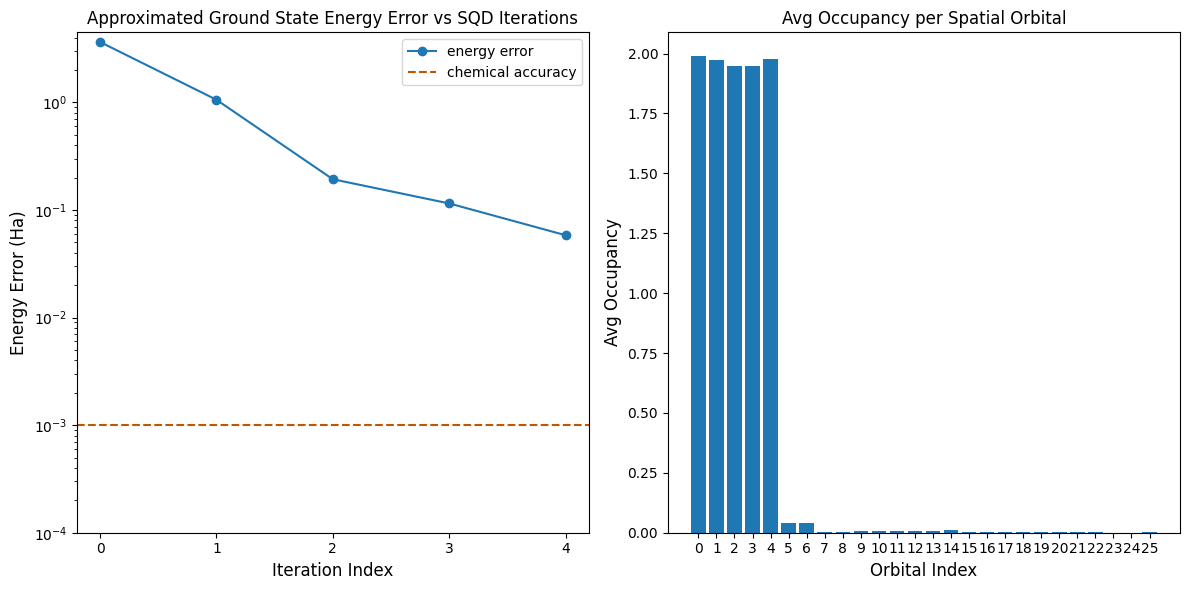

In [24]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
 
# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001
 
# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.show()

In [31]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
from typing import Sequence
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

## integrals, exact values, ...

# Specify molecule properties
open_shell = False
spin_sq = 0
 
R = 1.1

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (R, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
norb = len(active_space)
nelec = int(sum(scf.mo_occ[active_space]))
num_elec_a = (nelec + mol.spin) // 2
num_elec_b = (nelec - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, norb, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), norb)
 
# Store reference energy from SCI calculation performed separately
exact_energy = -109.2635773151638

## job
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/d0452a76f5f0435a94da777e07d63524:02dde04a-2cef-4099-97bb-ee03dd1b86e5::'
)
job = service.job('d38ofusda4cs73aa5kt0')
primitive_result = job.result()
pub_result = primitive_result[0]
bitstring_samples = pub_result.data.meas # noisy bitstrings


## SQD

from functools import partial
 
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)
 
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 10
 
# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
 
# List to capture intermediate results
result_history = []
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
result = diagonalize_fermionic_hamiltonian(hcore,eri,
    pub_result.data.meas,samples_per_batch=samples_per_batch,
    norb=norb,nelec = (num_elec_a, num_elec_b), num_batches=num_batches,
    energy_tol=energy_tol,occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,carryover_threshold=carryover_threshold,
    callback=callback,seed=12345,
)

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
 
# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001
 
# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o", c='r')
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="k",
    linestyle="--",
    label="chemical accuracy",
)

axs[0].set_xlabel("Iteration", fontdict={"fontsize": 12})
axs[0].set_ylabel(r"$|E-E_{SQD}|$ [Ha]", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.savefig("callback.png")
tikzplotlib.save("callback.tex", axis_width="0.5\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )

converged SCF energy = -108.953796240891
Iteration 1
	Subsample 0
		Energy: -103.1309768141589
		Subspace dimension: 196
	Subsample 1
		Energy: -103.1309768141589
		Subspace dimension: 196
	Subsample 2
		Energy: -103.1309768141589
		Subspace dimension: 196
Iteration 2
	Subsample 0
		Energy: -108.97689756570037
		Subspace dimension: 295936
	Subsample 1
		Energy: -107.00426153240416
		Subspace dimension: 294849
	Subsample 2
		Energy: -108.98413279603763
		Subspace dimension: 288369
Iteration 3
	Subsample 0
		Energy: -109.0834871289778
		Subspace dimension: 331776
	Subsample 1
		Energy: -109.11191204811618
		Subspace dimension: 339889
	Subsample 2
		Energy: -109.09986488813689
		Subspace dimension: 318096
Iteration 4
	Subsample 0
		Energy: -109.1761308014733
		Subspace dimension: 495616
	Subsample 1
		Energy: -109.17906973781194
		Subspace dimension: 480249
	Subsample 2
		Energy: -109.20354187005704
		Subspace dimension: 456976
Iteration 5
	Subsample 0
		Energy: -109.2163367479441
		Subsp

KeyboardInterrupt: 